In [8]:
import prior

dataset = prior.load_dataset("procthor-10k")
dataset

[AI2-THOR WARNING] There has been an update to ProcTHOR-10K that must be used with AI2-THOR version 5.0+. To use the new version of ProcTHOR-10K, please update AI2-THOR to version 5.0+ by running:
    pip install --upgrade ai2thor
Alternatively, to downgrade to the old version of ProcTHOR-10K, run:
   prior.load_dataset("procthor-10k", revision="ab3cacd0fc17754d4c080a3fd50b18395fae8647")


Loading test: 100%|██████████| 1000/1000 [00:00<00:00, 12066.47it/s]


DatasetDict(
    train=Dataset(
    dataset=procthor-dataset,
    size=10000,
    split=train
),
    val=Dataset(
    dataset=procthor-dataset,
    size=1000,
    split=val
),
    test=Dataset(
    dataset=procthor-dataset,
    size=1000,
    split=test
)
)

In [9]:
from ai2thor.controller import Controller


house = dataset["train"][3]
controller = Controller(scene=house, snapToGrid=False, rotateStepDegrees=30)
event = controller.step("Pass")
spawn = event.metadata["agent"]["position"]

/home/juyuanli/miniconda3/envs/nav_assistant/lib/python3.11/site-packages/ai2thor/platform.py:154: UserWarning: could not connect to X Display: 5, Can't connect to display ":5": b'Authorization required, but no authorization protocol specified\n'
  warnings.warn(


In [10]:
import numpy as np
def teleport(controller, target=None):
    event = controller.step("GetReachablePositions")
    reachable_positions = event.metadata["actionReturn"]
    # Pick a random target
    if target is None:
        target = np.random.choice(reachable_positions)

    event = controller.step(
        action="TeleportFull",
        x=target["x"],
        y=target["y"],
        z=target["z"],
        rotation={"x": 0, "y": 0, "z": 0},
        horizon=0,
        standing=True
    )

    return event


In [ ]:
from rl import PPO, ActorCritic, Env, RolloutBuffer, ClipEnv, CLIPNovelty
from models import LSTMActor, LSTMCritic, CompleteFrozenResNetEncoder, SlidingWindowTransformerActor, SlidingWindowTransformerCritic, SmallCNNEncoder
from cons import MINIBATCHES, EPISODE_STEPS, FEAT_DIM, NUM_ACTIONS, DEVICE

In [12]:
import torch
import matplotlib.pyplot as plt
from rl import save_actor_critic

def train(controller, name: str, ppo: PPO, env: Env, actor_critic: ActorCritic, total_updates=10):
    event = controller.step("Pass")  # prime
    rewards = []
    episode_rewards = []
    for upd in range(total_updates):
        buf = RolloutBuffer()
        for mb in range(MINIBATCHES):
            # collect episodes
            episode_seq = []
            episode_reward = 0
            actions_seq = []
            for t in range(1, EPISODE_STEPS + 1):
                with torch.no_grad():
                    obs_t = ppo.obs_from_event(event)  # (C,H,W)
                    obs_encoded = actor_critic.actor_critic_encoder(obs_t.unsqueeze(0).unsqueeze(0)).squeeze(0).squeeze(0) # (D)
                    obs_seq = torch.stack(episode_seq + [obs_encoded], dim=0).to(device=DEVICE)

                if len(actions_seq) == 0:
                    actions_seq.append(torch.randint(0, NUM_ACTIONS, (1, 1)).item())
                
                actions_tensor = torch.tensor(actions_seq, dtype=torch.long, device=DEVICE)
                logits, value = ppo.act_and_value(obs_seq, actions_tensor, actor_critic)
                dist = torch.distributions.Categorical(logits=logits)
                action_idx = dist.sample()
                logp = dist.log_prob(action_idx)
                
                action_idx, logp = action_idx.item(), logp.item()
                event, reward = env.step_env(controller, action_idx)
                done = t == EPISODE_STEPS

                # store one step
                buf.add(obs_t, action_idx, logp, reward, value, done)
                episode_seq.append(obs_encoded)
                rewards.append(reward)
                actions_seq.append(action_idx)
                
                episode_reward += reward / EPISODE_STEPS

                # 50% chance of teleport
                if done:
                    env.reset()
                    if np.random.rand() > 0.5:
                        event = teleport(controller)
            episode_rewards.append(episode_reward)
                
        ppo.ppo_update(buf, actor_critic)
        if (upd + 1) % 10 == 0:
            save_actor_critic(actor_critic, f"chkpoint_{upd}.pt")
        save_actor_critic(actor_critic, name)
        
        print(f"Update {upd+1}/{total_updates} — steps: {len(buf)}")
        plt.plot(rewards)
        plt.show()
        plt.plot(episode_rewards)
        plt.show()
    return buf, rewards

In [ ]:
ENTROPY_COEF = 0.05

ppo = PPO(ENTROPY_COEF)
encoder = CompleteFrozenResNetEncoder(FEAT_DIM)
actor = SlidingWindowTransformerActor(FEAT_DIM, NUM_ACTIONS)
critic = SlidingWindowTransformerCritic(FEAT_DIM)
clip_novelty = CLIPNovelty()
clip_env = ClipEnv(clip_novelty)
clip_actor_critic = ActorCritic(encoder, actor, critic)


In [ ]:
buf, rewards = train(controller, "clip_actor_critic_checkpoint_long_training.pt", ppo, clip_env, clip_actor_critic, 100)

[PPO] Epoch 0: Loss=88.0769, Policy=0.0110, Value=176.1808
[PPO] Epoch 10: Loss=30.1053, Policy=-0.0079, Value=60.2778
[PPO] Epoch 20: Loss=17.4728, Policy=-0.0293, Value=35.0505
[PPO] Epoch 30: Loss=10.0778, Policy=-0.0471, Value=20.2991
Approx KL Learned: 0.05416448414325714
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 1/100 — steps: 2048


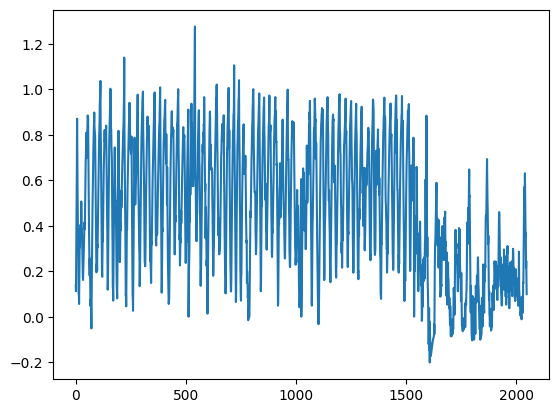

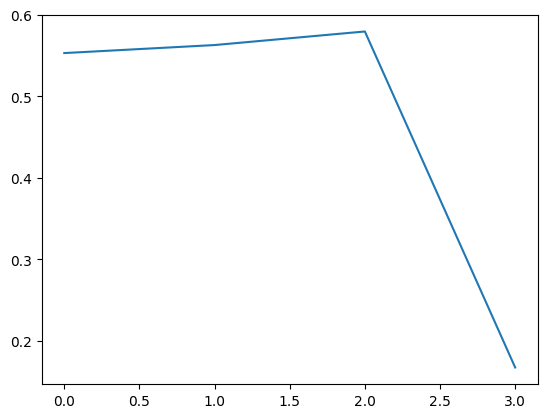

[PPO] Epoch 0: Loss=118.9301, Policy=0.0110, Value=237.9253
[PPO] Epoch 10: Loss=38.5040, Policy=0.0093, Value=77.0763
[PPO] Epoch 20: Loss=34.6468, Policy=-0.0077, Value=69.3943
[PPO] Epoch 30: Loss=30.2992, Policy=-0.0023, Value=60.6897
Approx KL Learned: 0.03507554903626442
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 2/100 — steps: 2048


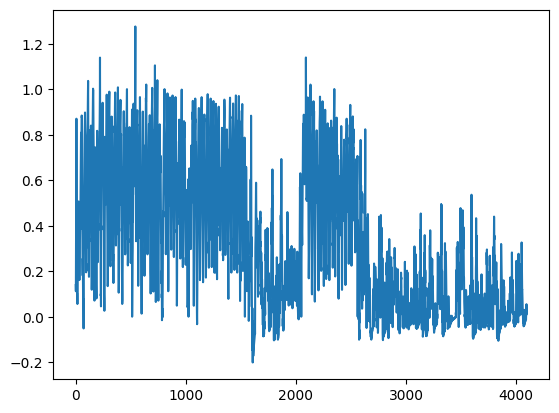

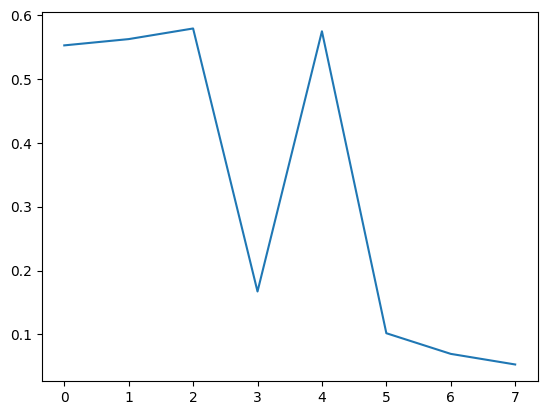

[PPO] Epoch 0: Loss=158.3675, Policy=0.0158, Value=316.7791
[PPO] Epoch 10: Loss=77.4949, Policy=0.0057, Value=155.0553
[PPO] Epoch 20: Loss=45.9489, Policy=-0.0220, Value=92.0196
[PPO] Epoch 30: Loss=35.6091, Policy=-0.0419, Value=71.3778
Approx KL Learned: 0.06047386676073074
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 3/100 — steps: 2048


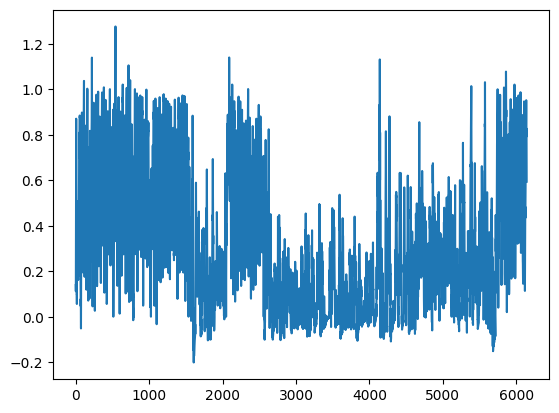

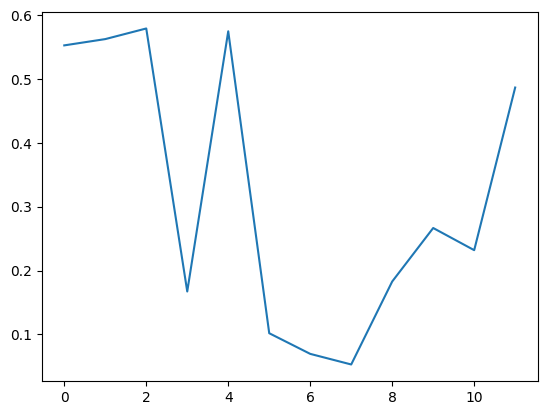

[PPO] Epoch 0: Loss=179.1168, Policy=0.0068, Value=358.2975
[PPO] Epoch 10: Loss=80.3137, Policy=0.0144, Value=160.6830
[PPO] Epoch 20: Loss=37.9387, Policy=-0.0140, Value=75.9932
[PPO] Epoch 30: Loss=21.4623, Policy=-0.0307, Value=43.0688
Approx KL Learned: 0.08193258941173553
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 4/100 — steps: 2048


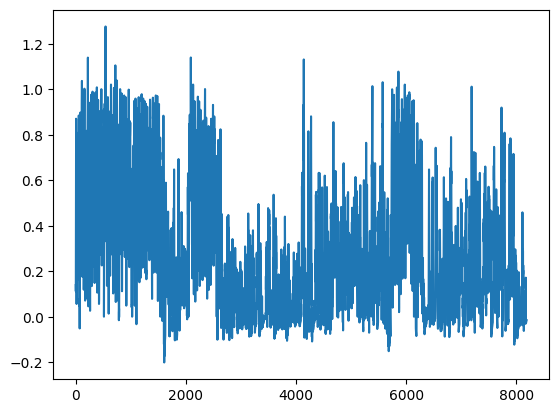

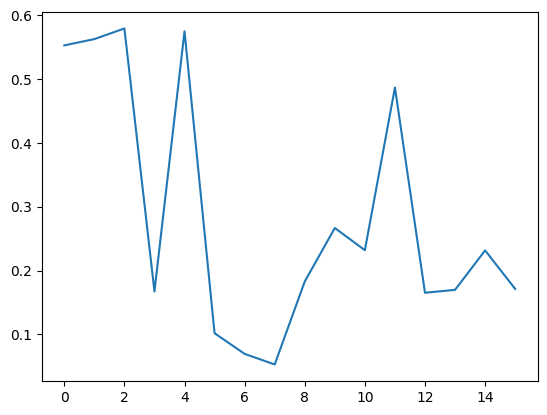

[PPO] Epoch 0: Loss=112.9537, Policy=0.0111, Value=225.9465
[PPO] Epoch 10: Loss=60.2272, Policy=-0.0044, Value=120.5255
[PPO] Epoch 20: Loss=38.4308, Policy=-0.0232, Value=76.9759
[PPO] Epoch 30: Loss=34.3651, Policy=-0.0456, Value=68.8886
Approx KL Learned: 0.09468930214643478
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 5/100 — steps: 2048


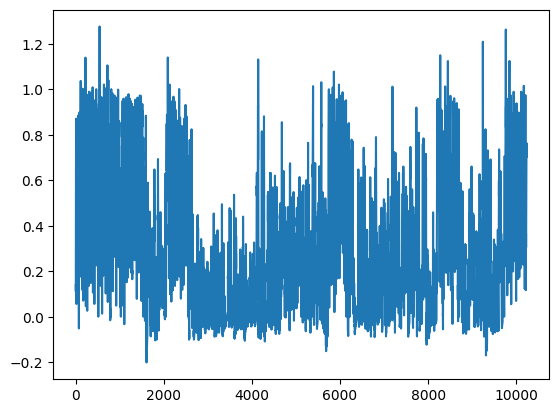

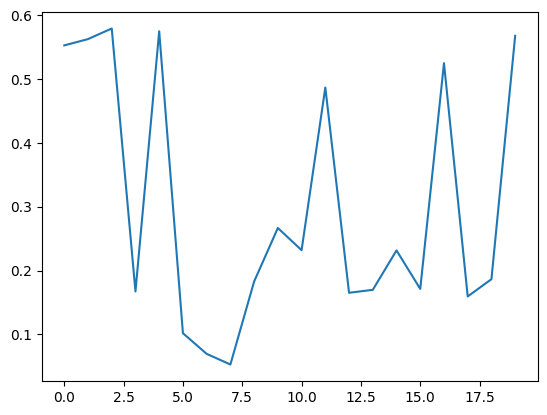

[PPO] Epoch 0: Loss=163.0760, Policy=0.0132, Value=326.1654
[PPO] Epoch 10: Loss=57.4838, Policy=0.0061, Value=114.9953
[PPO] Epoch 20: Loss=36.2213, Policy=0.0009, Value=72.4814
[PPO] Epoch 30: Loss=21.0974, Policy=-0.0129, Value=42.2629
Approx KL Learned: 0.06790877878665924
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 6/100 — steps: 2048


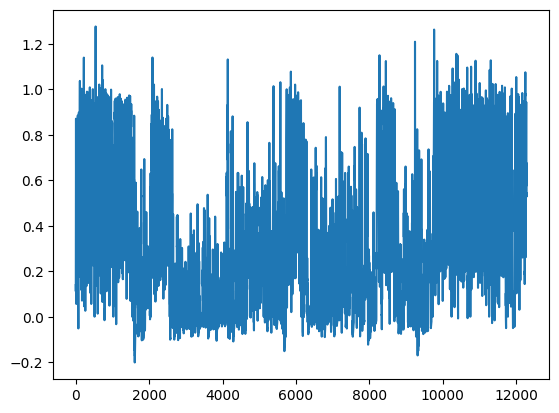

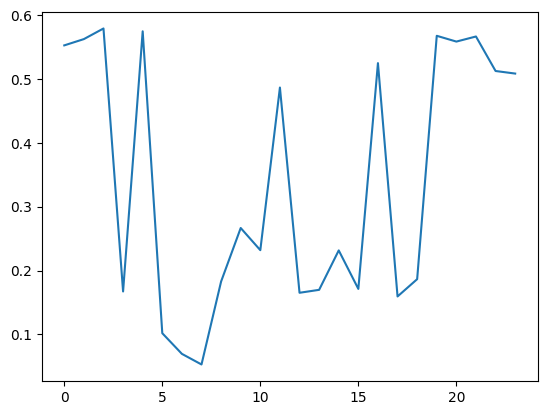

[PPO] Epoch 0: Loss=130.7062, Policy=0.0150, Value=261.4396
[PPO] Epoch 10: Loss=53.6498, Policy=0.0053, Value=107.3400
[PPO] Epoch 20: Loss=23.2827, Policy=-0.0173, Value=46.6516
[PPO] Epoch 30: Loss=18.5008, Policy=-0.0269, Value=37.1108
Approx KL Learned: 0.0548524372279644
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 7/100 — steps: 2048


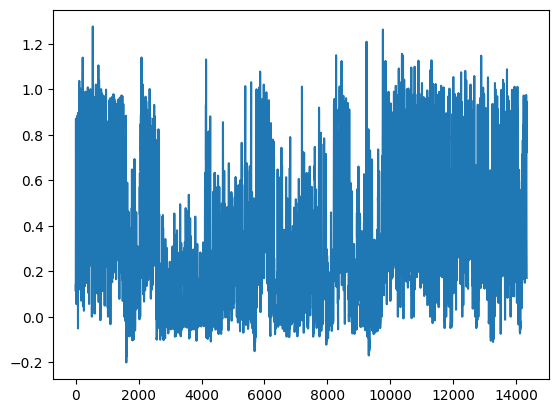

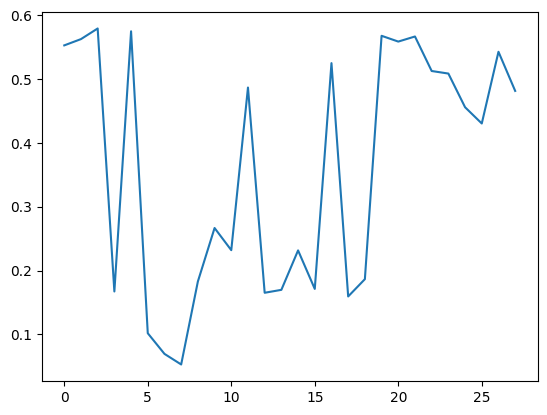

[PPO] Epoch 0: Loss=81.3106, Policy=0.0139, Value=162.6497
[PPO] Epoch 10: Loss=24.5657, Policy=-0.0041, Value=49.1938
[PPO] Epoch 20: Loss=15.5588, Policy=-0.0157, Value=31.2025
[PPO] Epoch 30: Loss=7.7016, Policy=-0.0378, Value=15.5334
Approx KL Learned: 0.02943704091012478
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 8/100 — steps: 2048


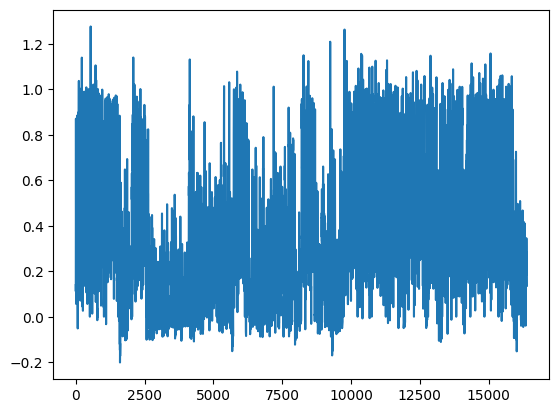

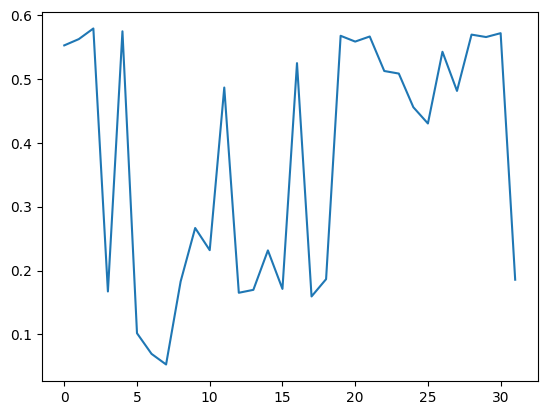

[PPO] Epoch 0: Loss=76.1420, Policy=0.0104, Value=152.3048
[PPO] Epoch 10: Loss=33.7571, Policy=-0.0002, Value=67.5489
[PPO] Epoch 20: Loss=19.5022, Policy=-0.0147, Value=39.0746
[PPO] Epoch 30: Loss=15.6363, Policy=-0.0189, Value=31.3537
Approx KL Learned: 0.0577954426407814
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 9/100 — steps: 2048


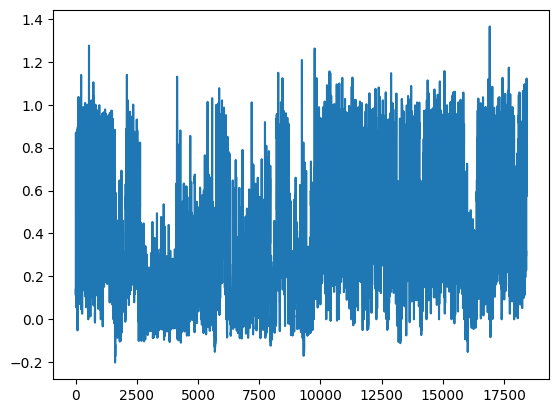

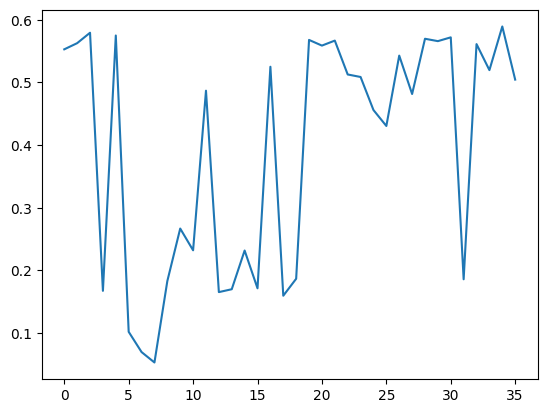

[PPO] Epoch 0: Loss=65.4605, Policy=0.0068, Value=130.9464
[PPO] Epoch 10: Loss=37.5556, Policy=-0.0014, Value=75.1552
[PPO] Epoch 20: Loss=26.3425, Policy=-0.0116, Value=52.7543
[PPO] Epoch 30: Loss=17.5477, Policy=-0.0273, Value=35.1977
Approx KL Learned: 0.07614479959011078
[✅] Actor-Critic checkpoint saved to chkpoint_9.pt
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 10/100 — steps: 2048


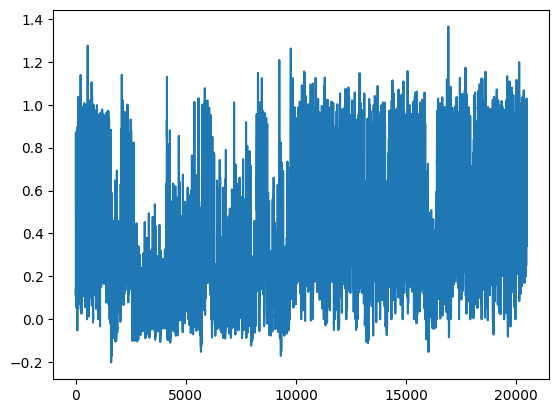

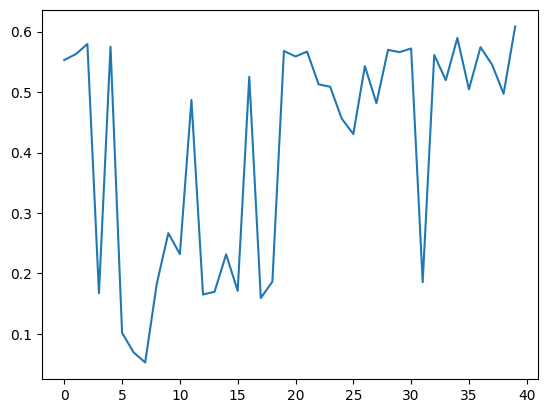

[PPO] Epoch 0: Loss=85.4142, Policy=0.0075, Value=170.8826
[PPO] Epoch 10: Loss=37.8107, Policy=-0.0108, Value=75.7091
[PPO] Epoch 20: Loss=23.4573, Policy=-0.0312, Value=47.0436
[PPO] Epoch 30: Loss=13.9388, Policy=-0.0460, Value=28.0359
Approx KL Learned: 0.04759887978434563
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 11/100 — steps: 2048


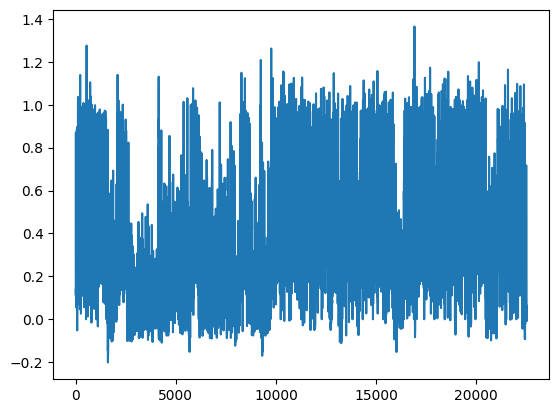

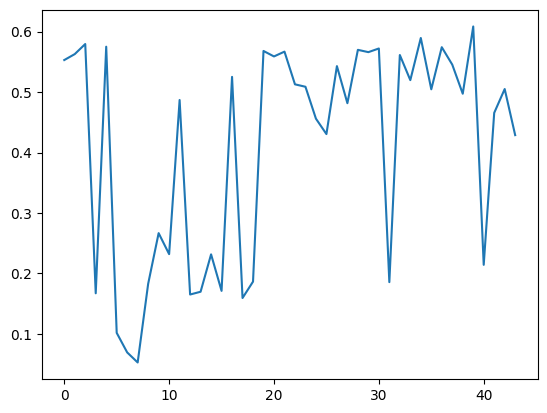

[PPO] Epoch 0: Loss=67.8909, Policy=0.0234, Value=135.7788
[PPO] Epoch 10: Loss=32.2581, Policy=0.0012, Value=64.5533
[PPO] Epoch 20: Loss=17.9830, Policy=-0.0261, Value=36.0628
[PPO] Epoch 30: Loss=13.5427, Policy=-0.0379, Value=27.2057
Approx KL Learned: 0.09436649084091187
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 12/100 — steps: 2048


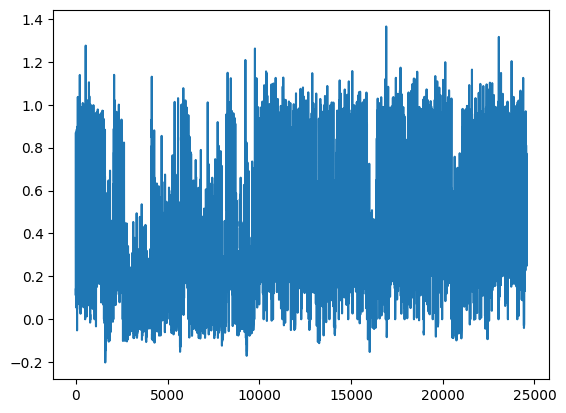

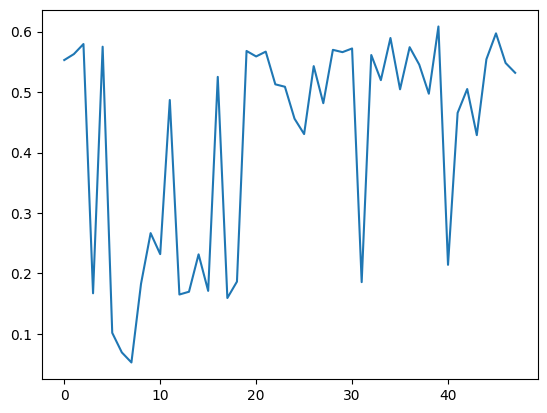

[PPO] Epoch 0: Loss=137.4070, Policy=0.0063, Value=274.9008
[PPO] Epoch 10: Loss=71.3544, Policy=-0.0003, Value=142.8084
[PPO] Epoch 20: Loss=34.5952, Policy=-0.0175, Value=69.3238
[PPO] Epoch 30: Loss=31.2920, Policy=-0.0352, Value=62.7493
Approx KL Learned: 0.027527639642357826
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 13/100 — steps: 2048


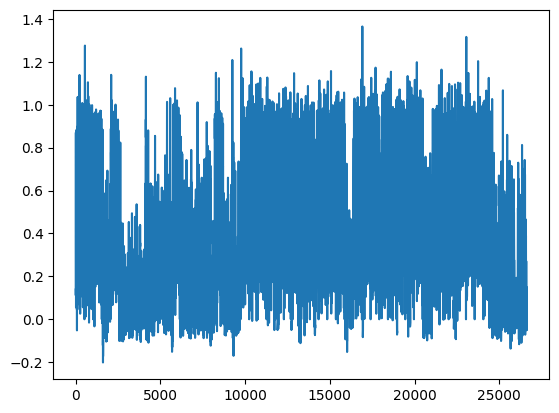

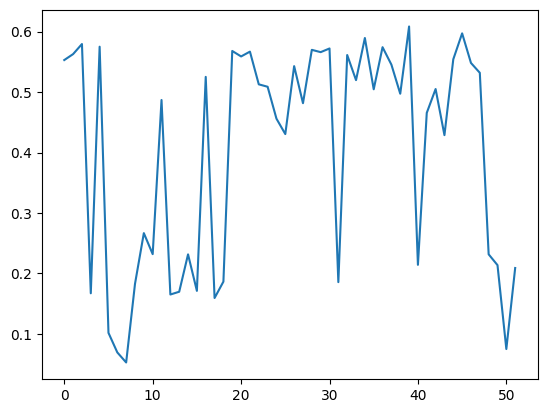

[PPO] Epoch 0: Loss=99.9047, Policy=0.0152, Value=199.8522
[PPO] Epoch 10: Loss=30.3247, Policy=-0.0065, Value=60.7339
[PPO] Epoch 20: Loss=16.0477, Policy=-0.0325, Value=32.2301
[PPO] Epoch 30: Loss=7.5979, Policy=-0.0641, Value=15.3918
Approx KL Learned: 0.07055783271789551
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 14/100 — steps: 2048


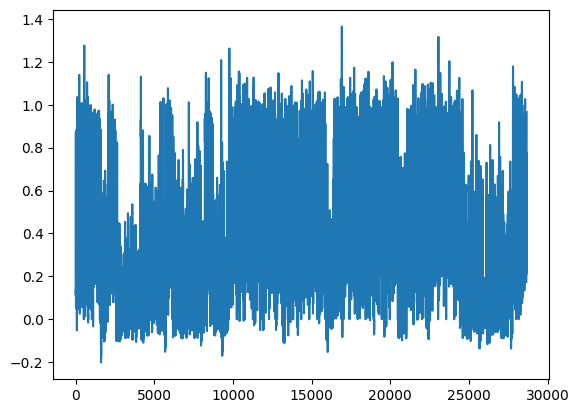

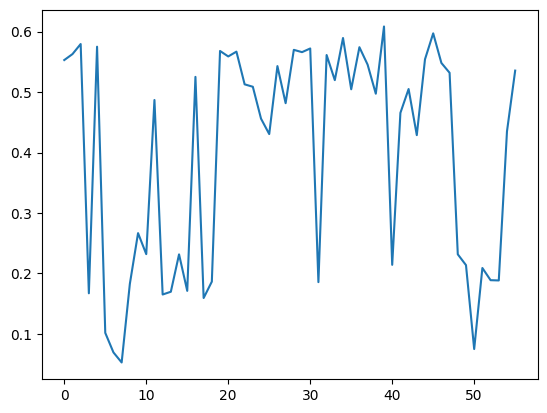

[PPO] Epoch 0: Loss=74.2911, Policy=0.0158, Value=148.5963
[PPO] Epoch 10: Loss=24.2394, Policy=0.0024, Value=48.5170
[PPO] Epoch 20: Loss=12.3052, Policy=-0.0305, Value=24.7164
[PPO] Epoch 30: Loss=5.3260, Policy=-0.0541, Value=10.8024
Approx KL Learned: 0.07560886442661285
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 15/100 — steps: 2048


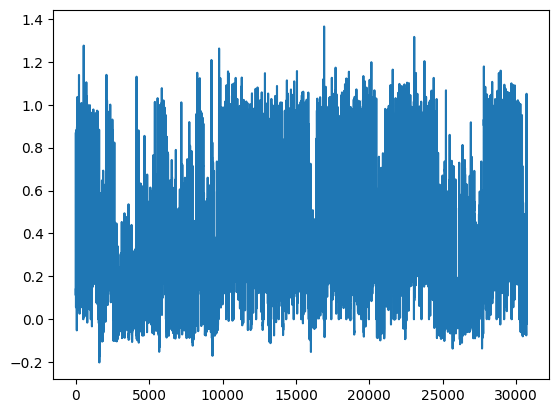

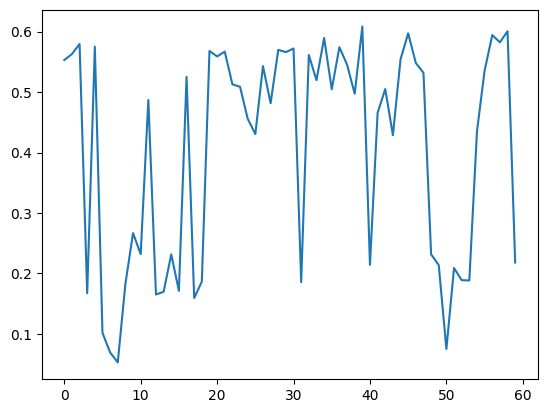

[PPO] Epoch 0: Loss=99.5007, Policy=0.0175, Value=199.0437
[PPO] Epoch 10: Loss=51.2556, Policy=0.0161, Value=102.5555
[PPO] Epoch 20: Loss=28.4018, Policy=-0.0135, Value=56.9118
[PPO] Epoch 30: Loss=18.2535, Policy=-0.0387, Value=36.6624
Approx KL Learned: 0.07141362130641937
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 16/100 — steps: 2048


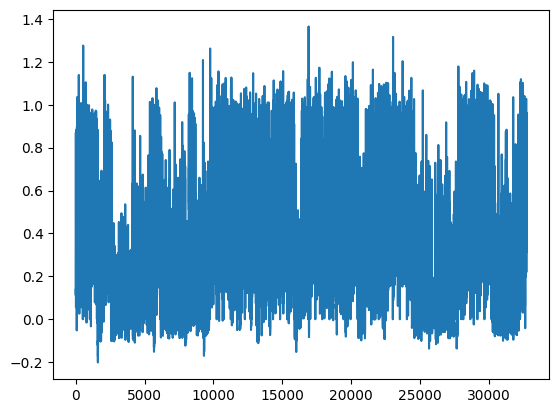

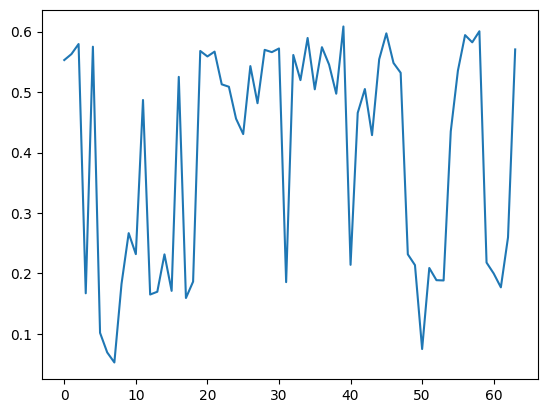

[PPO] Epoch 0: Loss=101.2782, Policy=0.0195, Value=202.5395
[PPO] Epoch 10: Loss=35.3122, Policy=0.0102, Value=70.6260
[PPO] Epoch 20: Loss=20.6400, Policy=-0.0128, Value=41.3399
[PPO] Epoch 30: Loss=10.2932, Policy=-0.0219, Value=20.6728
Approx KL Learned: 0.18926341831684113
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 17/100 — steps: 2048


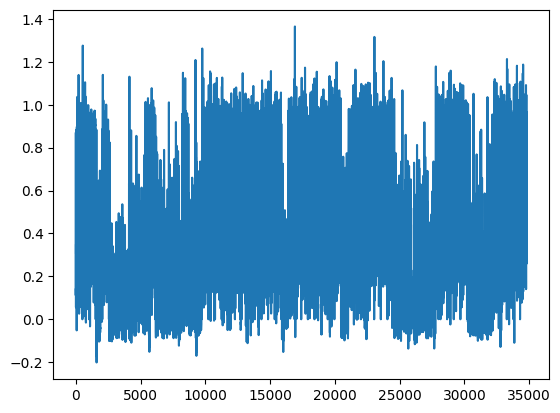

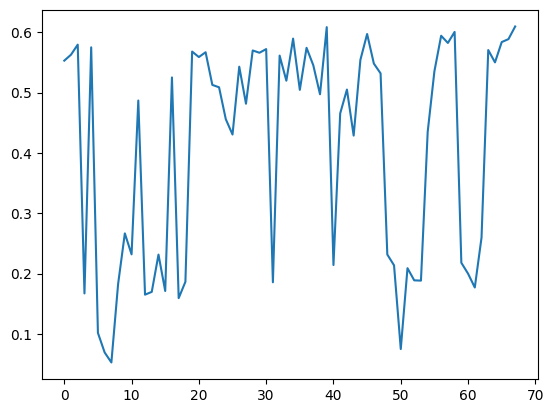

[PPO] Epoch 0: Loss=125.1981, Policy=0.0150, Value=250.4429
[PPO] Epoch 10: Loss=51.4357, Policy=0.0193, Value=102.9107
[PPO] Epoch 20: Loss=24.4931, Policy=-0.0243, Value=49.1127
[PPO] Epoch 30: Loss=12.9927, Policy=-0.0386, Value=26.1442
Approx KL Learned: 0.09935830533504486
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 18/100 — steps: 2048


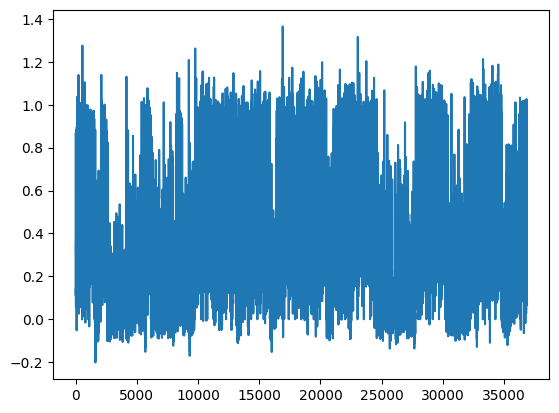

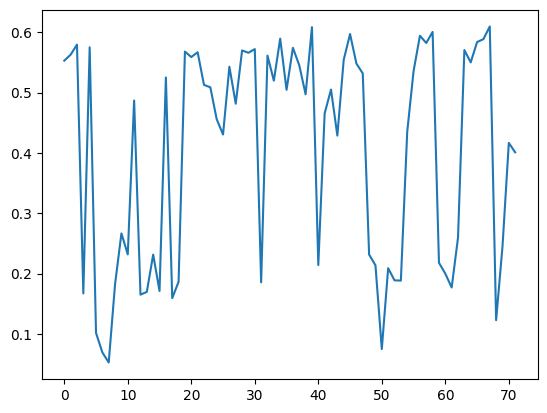

[PPO] Epoch 0: Loss=92.3569, Policy=0.0088, Value=184.7599
[PPO] Epoch 10: Loss=42.0963, Policy=-0.0051, Value=84.2636
[PPO] Epoch 20: Loss=23.7494, Policy=-0.0220, Value=47.6021
[PPO] Epoch 30: Loss=12.9891, Policy=-0.0421, Value=26.1217
Approx KL Learned: 0.038148850202560425
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 19/100 — steps: 2048


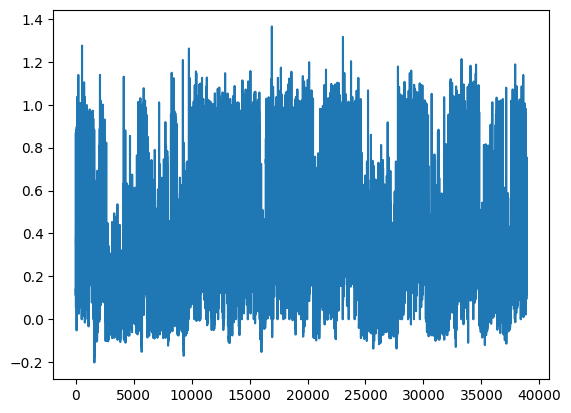

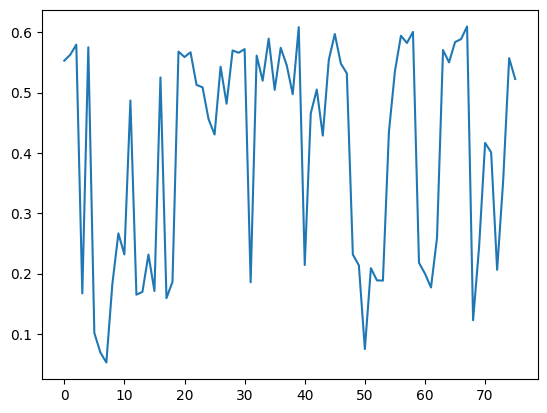

[PPO] Epoch 0: Loss=98.2755, Policy=0.0055, Value=196.5950
[PPO] Epoch 10: Loss=31.5976, Policy=-0.0056, Value=63.2594
[PPO] Epoch 20: Loss=19.7369, Policy=-0.0297, Value=39.5866
[PPO] Epoch 30: Loss=12.2691, Policy=-0.0438, Value=24.6804
Approx KL Learned: 0.05399185046553612
[✅] Actor-Critic checkpoint saved to chkpoint_19.pt
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 20/100 — steps: 2048


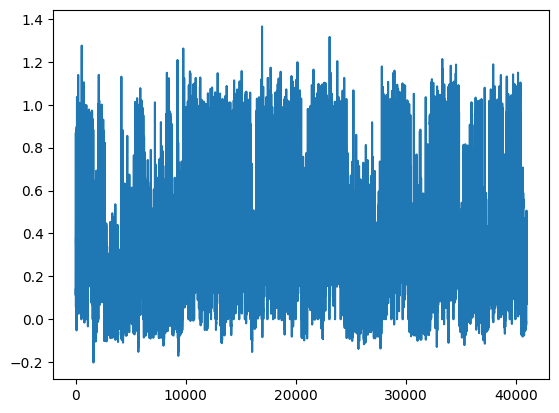

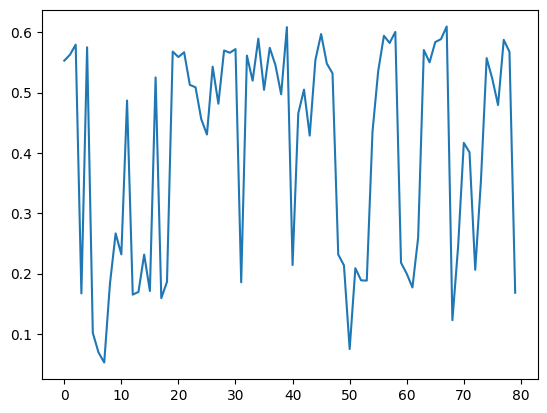

[PPO] Epoch 0: Loss=73.3421, Policy=0.0106, Value=146.6986
[PPO] Epoch 10: Loss=28.9853, Policy=-0.0035, Value=58.0151
[PPO] Epoch 20: Loss=16.0031, Policy=-0.0198, Value=32.0874
[PPO] Epoch 30: Loss=10.5490, Policy=-0.0287, Value=21.2062
Approx KL Learned: 0.08354903757572174
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 21/100 — steps: 2048


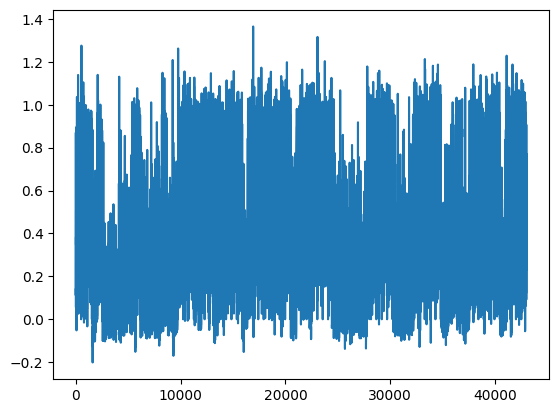

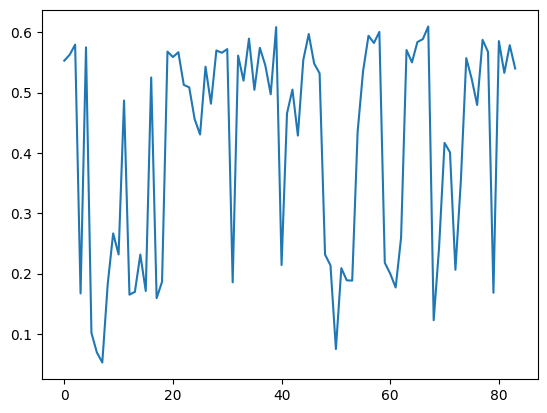

[PPO] Epoch 0: Loss=124.6062, Policy=0.0134, Value=249.2467
[PPO] Epoch 10: Loss=47.6075, Policy=-0.0054, Value=95.2822
[PPO] Epoch 20: Loss=28.0017, Policy=-0.0213, Value=56.1095
[PPO] Epoch 30: Loss=17.5199, Policy=-0.0309, Value=35.1656
Approx KL Learned: 0.15578165650367737
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 22/100 — steps: 2048


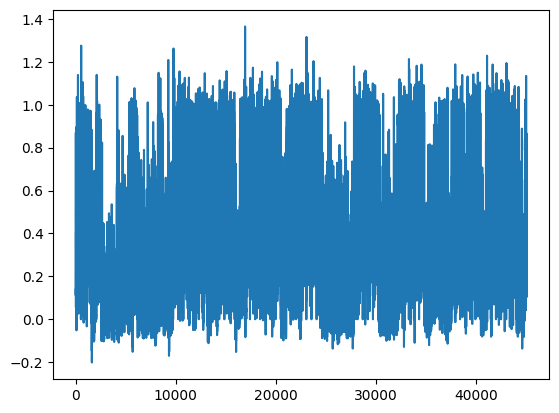

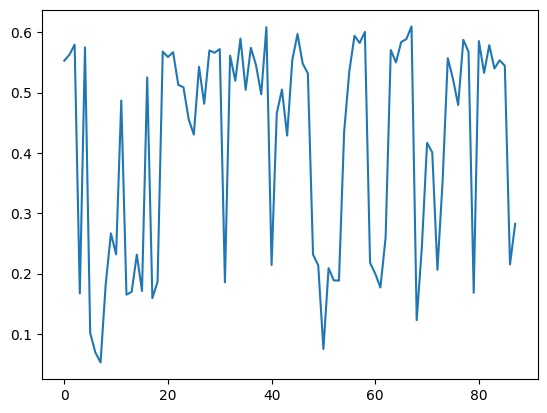

[PPO] Epoch 0: Loss=55.8482, Policy=0.0189, Value=111.6990
[PPO] Epoch 10: Loss=22.5364, Policy=0.0022, Value=45.1131
[PPO] Epoch 20: Loss=11.9368, Policy=-0.0282, Value=23.9766
[PPO] Epoch 30: Loss=12.7988, Policy=-0.0341, Value=25.7102
Approx KL Learned: 0.10570017248392105
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 23/100 — steps: 2048


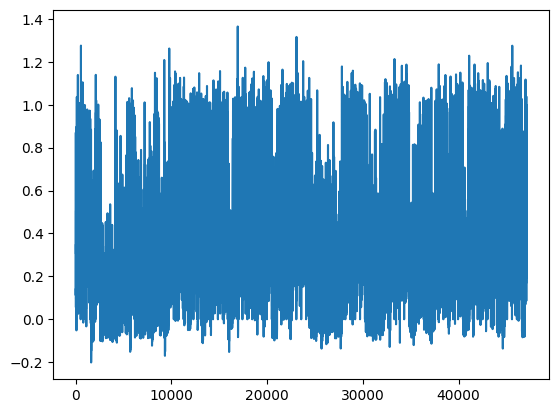

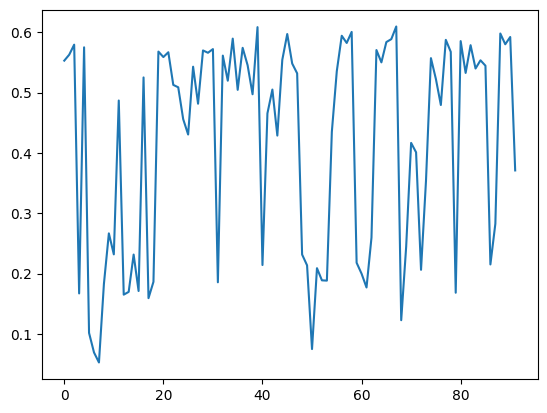

[PPO] Epoch 0: Loss=33.1066, Policy=0.0120, Value=66.2283
[PPO] Epoch 10: Loss=18.4110, Policy=0.0018, Value=36.8537
[PPO] Epoch 20: Loss=11.7801, Policy=-0.0195, Value=23.6396
[PPO] Epoch 30: Loss=7.4449, Policy=-0.0349, Value=15.0013
Approx KL Learned: 0.07244516909122467
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 24/100 — steps: 2048


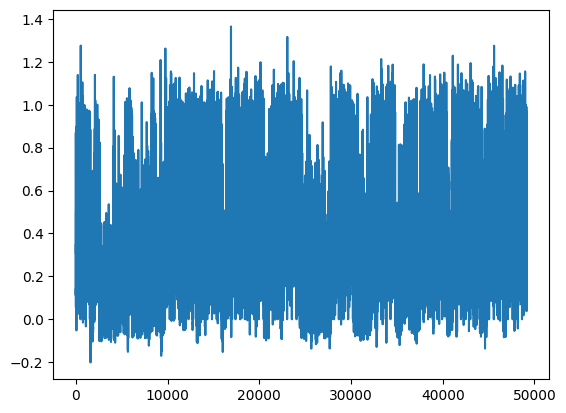

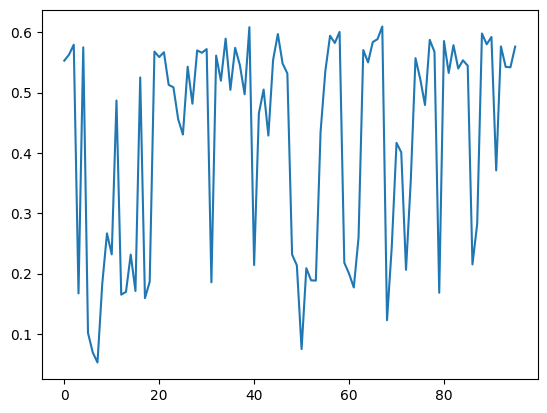

KeyboardInterrupt: 

In [12]:
buf, rewards = train(controller, "clip_actor_critic_checkpoint_long_training.pt", ppo, clip_env, clip_actor_critic, 100)

In [8]:
from rl import load_actor_critic

load_actor_critic(clip_actor_critic, "chkpoint_99.pt")

[🔁] Actor-Critic checkpoint loaded from chkpoint_99.pt


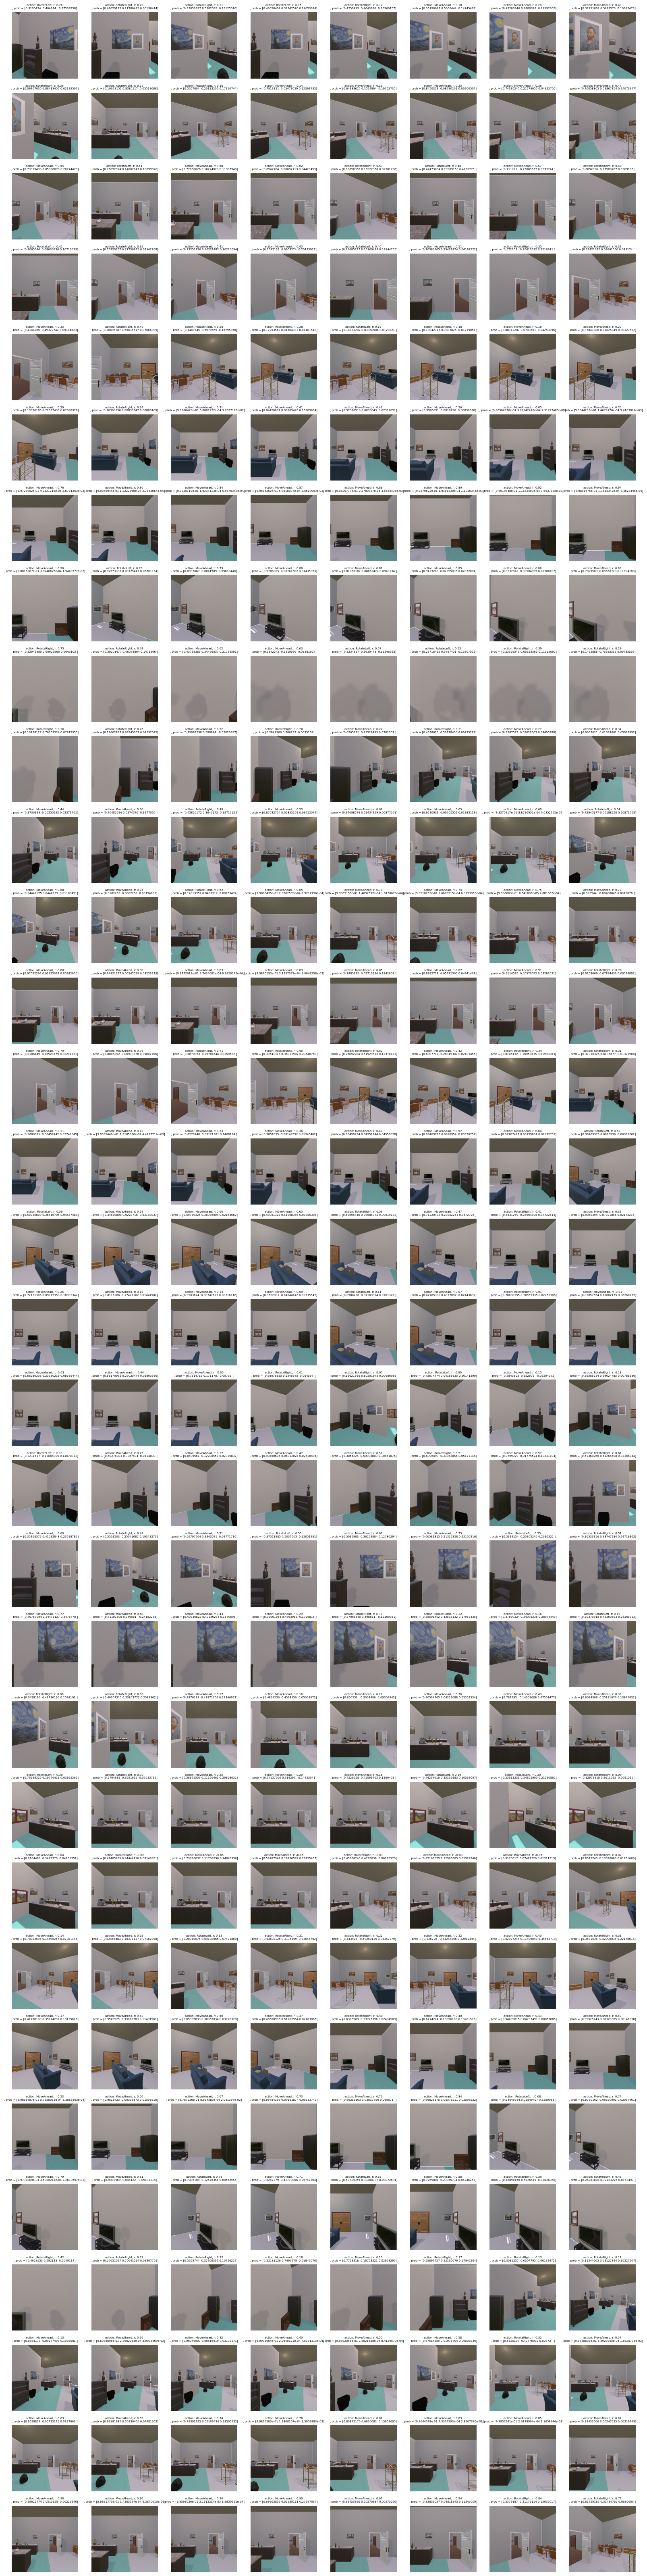

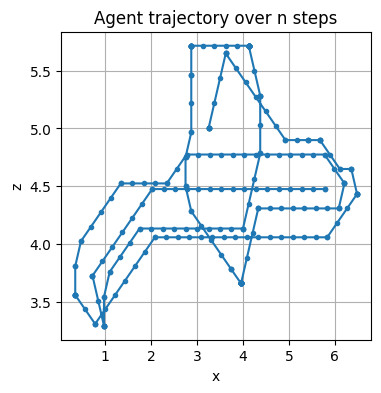

[tensor([[[0.5804, 0.5804, 0.5804,  ..., 0.3686, 0.3686, 0.3686],
          [0.5804, 0.5804, 0.5804,  ..., 0.3686, 0.3686, 0.3686],
          [0.5804, 0.5804, 0.5804,  ..., 0.3647, 0.3647, 0.3647],
          ...,
          [0.1608, 0.1608, 0.1608,  ..., 0.4235, 0.4235, 0.4235],
          [0.1608, 0.1608, 0.1608,  ..., 0.4196, 0.4196, 0.4196],
          [0.1608, 0.1608, 0.1608,  ..., 0.4118, 0.4157, 0.4196]],
 
         [[0.5490, 0.5490, 0.5490,  ..., 0.3412, 0.3412, 0.3412],
          [0.5490, 0.5490, 0.5490,  ..., 0.3412, 0.3412, 0.3412],
          [0.5490, 0.5490, 0.5490,  ..., 0.3412, 0.3412, 0.3412],
          ...,
          [0.1333, 0.1333, 0.1333,  ..., 0.6118, 0.6118, 0.6157],
          [0.1333, 0.1333, 0.1333,  ..., 0.6078, 0.6078, 0.6078],
          [0.1333, 0.1333, 0.1333,  ..., 0.6000, 0.6078, 0.6078]],
 
         [[0.5569, 0.5569, 0.5569,  ..., 0.2863, 0.2824, 0.2824],
          [0.5569, 0.5569, 0.5569,  ..., 0.2824, 0.2824, 0.2824],
          [0.5569, 0.5569, 0.5569,  ...,

In [27]:
from cons import ACTIONS
from collections import deque
import matplotlib.pyplot as plt
import numpy as np
from typing import Callable
import imageio


def inference(get_distribution: Callable[[torch.Tensor, ActorCritic], torch.distributions.Categorical], init_position: dict[str, float], env: Env, actor_critic: ActorCritic, plot=True):
    n = 256
    n_row = 32
    positions = []

    plt.figure(figsize=(n // n_row * 2, n_row * 2))
    event = teleport(controller, init_position)
    episode_seq = deque(maxlen=EPISODE_STEPS)
    actions_seq = deque(maxlen=EPISODE_STEPS)
    raw_obs = []
    for t in range(1, n + 1):
        positions.append([event.metadata["agent"]["position"]["x"], event.metadata["agent"]["position"]["z"]])
        with torch.no_grad():
            obs_t = ppo.obs_from_event(event)  # (C,H,W)
            obs_t_encoded = actor_critic.actor_critic_encoder(obs_t.unsqueeze(0).unsqueeze(0)).squeeze(0).squeeze(0)
            obs_seq = torch.stack(list(episode_seq) + [obs_t_encoded], dim=0).to(device=DEVICE)

        if len(actions_seq) == 0:
            actions_seq.append(torch.randint(0, NUM_ACTIONS, (1, 1)).item())
        
        actions_tensor = torch.tensor(actions_seq, dtype=torch.long, device=DEVICE).unsqueeze(0)
        dist = get_distribution(obs_seq, actions_tensor, actor_critic)
        action_idx = dist.sample()
        logp = dist.log_prob(action_idx)
        
        action_idx, logp = action_idx.item(), logp.item()
        event, reward = env.step_env(controller, action_idx)

        # store one step
        episode_seq.append(obs_t_encoded)
        actions_seq.append(action_idx)
        raw_obs.append(obs_t)
        
        if plot:
            # Plot frame and action
            plt.subplot(n_row, n // n_row, t)
            plt.title("action: " + ACTIONS[action_idx] + ", r: " + f"{reward:.2f}" + "\n, prob = " + f"{torch.exp(dist.log_prob(torch.tensor([0, 1, 2], device=DEVICE))).cpu().numpy()}", fontsize=5)
            plt.axis(False)
            plt.imshow(event.frame)
    if plot:
        plt.tight_layout()
        plt.show()
        
        # ---- Plot 2D trajectory of the agent ----
        positions = np.array(positions)
        plt.figure(figsize=(4, 4))
        plt.plot(positions[:, 0], positions[:, 1], "-o", markersize=3)
        plt.xlabel("x")
        plt.ylabel("z")
        plt.title("Agent trajectory over n steps")
        plt.grid(True)
        plt.show()

    return raw_obs

def inference_video_mp4(
    get_distribution,
    init_position: dict[str, float],
    env: Env,
    actor_critic: ActorCritic,
    video_path="rollout.mp4",
    fps=10,
    n_steps=256
):
    episode_seq = deque(maxlen=EPISODE_STEPS)
    actions_seq = deque(maxlen=EPISODE_STEPS)

    writer = imageio.get_writer(video_path, fps=fps)

    # start episode
    event = teleport(controller, init_position)
    positions = []

    for t in range(1, n_steps + 1):

        # ---- Add current frame to video ----
        writer.append_data(event.frame)   # convert RGB→BGR if needed

        # track positions
        positions.append([
            event.metadata["agent"]["position"]["x"],
            event.metadata["agent"]["position"]["z"],
        ])

        with torch.no_grad():
            obs_t = ppo.obs_from_event(event)  
            obs_enc = actor_critic.actor_critic_encoder(
                obs_t.unsqueeze(0).unsqueeze(0)
            ).squeeze(0).squeeze(0)

            obs_seq = torch.stack(
                list(episode_seq) + [obs_enc], dim=0
            ).to(DEVICE)

        # ---- Action ----
        if len(actions_seq) == 0:
            actions_seq.append(torch.randint(0, NUM_ACTIONS, ()).item())

        actions_tensor = torch.tensor(
            actions_seq, dtype=torch.long, device=DEVICE
        ).unsqueeze(0)

        dist = get_distribution(obs_seq, actions_tensor, actor_critic)
        action_idx = dist.sample().item()

        # ---- Step env ----
        event, reward = env.step_env(controller, action_idx)

        # ---- Store ----
        episode_seq.append(obs_enc)
        actions_seq.append(action_idx)

    writer.close()
    print(f"[🎞️] Saved video to {video_path}")

    return positions


def get_distributions(obs_seq, actions_tensor, clip_actor_critic):
    logits, value = ppo.act_and_value(obs_seq, actions_tensor, clip_actor_critic)
    dist = torch.distributions.Categorical(logits=logits)
    return dist

event = teleport(controller)
init_pos = event.metadata["agent"]["position"]
init_pos = {'x': 3.25, 'y': 0.9009997844696045, 'z': 5.0}
inference(get_distributions, init_pos, clip_env, clip_actor_critic)

In [34]:
!pip install imageio imageio-ffmpeg

In [22]:
import clip

model, preprocess = clip.load("ViT-B/32", device=DEVICE)

In [23]:
import torch
import torch.nn.functional as F
import random

def preprocess_clip(x):
    # Resize to CLIP resolution
    x = F.interpolate(x, size=(224, 224), mode="bilinear", align_corners=False)
    # Normalize (CLIP standard mean/std)
    mean = torch.tensor([0.48145466, 0.4578275, 0.40821073], device=x.device).view(1, 3, 1, 1)
    std  = torch.tensor([0.26862954, 0.26130258, 0.27577711], device=x.device).view(1, 3, 1, 1)
    return (x - mean) / std

def get_average(input_img):
    # ---- 1. Sample 50 random images ----
    n = min(50, len(input_img))
    indices = random.sample(range(len(input_img)), n)
    imgs = torch.stack([input_img[i] for i in indices]).to(DEVICE)  # (50, 3, H, W)

    # ---- 2. Preprocess for CLIP ----
    imgs_clip = preprocess_clip(imgs).half()  # normalized, resized

    # ---- 3. Encode with CLIP visual encoder ----
    with torch.no_grad():
        embeds = model.visual(imgs_clip)       # (50, D)
        embeds = embeds / embeds.norm(dim=-1, keepdim=True)  # normalize to unit sphere

    # ---- 4. Compute cosine similarity ----
    sim_matrix = embeds @ embeds.T             # (50, 50)
    # Optional: remove self-similarity (diagonal = 1)
    sim_matrix.fill_diagonal_(0)

    # ---- 5. Summary statistics ----
    mean_sim = sim_matrix.mean().item()

    return mean_sim

for i in range(5):

    event = teleport(controller)
    init_pos = event.metadata["agent"]["position"]
    
    def get_distributions(obs_seq, actions_tensor, clip_actor_critic):
        logits, value = ppo.act_and_value(obs_seq, actions_tensor, clip_actor_critic)
        dist = torch.distributions.Categorical(logits=logits)
        return dist

    policy = inference(get_distributions, init_pos, clip_env, clip_actor_critic, False)

    def get_distributions(obs_seq, actions_tensor, clip_actor_critic):
        dist = torch.distributions.Categorical(probs=torch.tensor([0.5, 0.25, 0.25], device=DEVICE))
        return dist

    rand_policy = inference(get_distributions, init_pos, clip_env, clip_actor_critic, False)

    mean_policies = []
    mean_rands = []
    for i in range(10):
        mean_policy = get_average(policy)
        mean_rand = get_average(rand_policy)
        mean_policies.append(mean_policy)
        mean_rands.append(mean_rand)
    
    print("Policy: " + str(np.mean(np.array(mean_policies))))
    print("Rand: " + str(np.mean(np.array(mean_rands))))



Policy: 0.877001953125
Rand: 0.86337890625
Policy: 0.87021484375
Rand: 0.8068359375
Policy: 0.83388671875
Rand: 0.845361328125
Policy: 0.8791015625
Rand: 0.876318359375
Policy: 0.80693359375
Rand: 0.79033203125


<Figure size 1600x6400 with 0 Axes>

<Figure size 1600x6400 with 0 Axes>

<Figure size 1600x6400 with 0 Axes>

<Figure size 1600x6400 with 0 Axes>

<Figure size 1600x6400 with 0 Axes>

<Figure size 1600x6400 with 0 Axes>

<Figure size 1600x6400 with 0 Axes>

<Figure size 1600x6400 with 0 Axes>

<Figure size 1600x6400 with 0 Axes>

<Figure size 1600x6400 with 0 Axes>